
# Food‑11 — Single Image Test (YOLO11n‑cls)

This notebook loads Food‑11 `best.pt`** and classifies the image:
```
/utilities/util_test_images/pasta-carbonara.png
```
It prints **Top‑1** and **Top‑5** predictions and saves an annotated image in your models folder.


In [2]:

# --- 1) Setup paths ------------------------------------------------------------
IMAGE_PATH = "/home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg"  # ← change if needed
MODEL_DIR  = "/home/kristoffel/models"
DATASET    = "/home/kristoffel/datasets/dataset-03-Food-11"    # not strictly needed for predict; here for reference

import os, glob, sys
assert os.path.isfile(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"
assert os.path.isdir(MODEL_DIR), f"Model dir not found: {MODEL_DIR}"
print("Image:", IMAGE_PATH)
print("Model dir:", MODEL_DIR)


Image: /home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg
Model dir: /home/kristoffel/models


In [3]:

# --- 2) Find newest Food-11 best.pt -------------------------------------------
import os, glob

RUN_PREFIX = "food11_yolo11n_cls"
cands = glob.glob(os.path.join(MODEL_DIR, RUN_PREFIX + "*", "weights", "best.pt"))
if not cands:
    raise FileNotFoundError(f"No 'best.pt' found matching {MODEL_DIR}/{RUN_PREFIX}*/weights/best.pt")
BEST_WEIGHTS = max(cands, key=os.path.getmtime)
print("Using weights:", BEST_WEIGHTS)


Using weights: /home/kristoffel/models/food11_yolo11n_cls3/weights/best.pt


In [4]:

# --- 3) Predict ----------------------------------------------------------------
# If ultralytics is not found, un-comment the pip line and re-run
# !pip install -U ultralytics

import torch
from ultralytics import YOLO

device = 0 if torch.cuda.is_available() else "cpu"
print("CUDA available:", torch.cuda.is_available())

model = YOLO(BEST_WEIGHTS)
# imgsz should match training; 224 is what we used in your Food-11 notebook
results = model.predict(
    source=IMAGE_PATH,
    imgsz=224,
    device=device,
    save=True,                         # saves annotated image
    project=MODEL_DIR,                 # under your models folder
    name="food11_single_inference"     # subfolder for this single test
)
print("Saved annotated image to:", os.path.join(MODEL_DIR, "food11_single_inference"))


CUDA available: True

image 1/1 /home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg: 224x224 Noodles-Pasta 1.00, Soup 0.00, Dessert 0.00, Egg 0.00, Bread 0.00, 5.0ms
Speed: 14.3ms preprocess, 5.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /home/kristoffel/models/food11_single_inference
Saved annotated image to: /home/kristoffel/models/food11_single_inference


Top-1: Noodles-Pasta  (confidence=1.0000)


,rank,class,confidence
0,1,Noodles-Pasta,1.000000e+00
1,2,Soup,1.799157e-08
2,3,Dessert,4.329759e-10
3,4,Egg,3.012409e-10
4,5,Bread,1.840310e-11


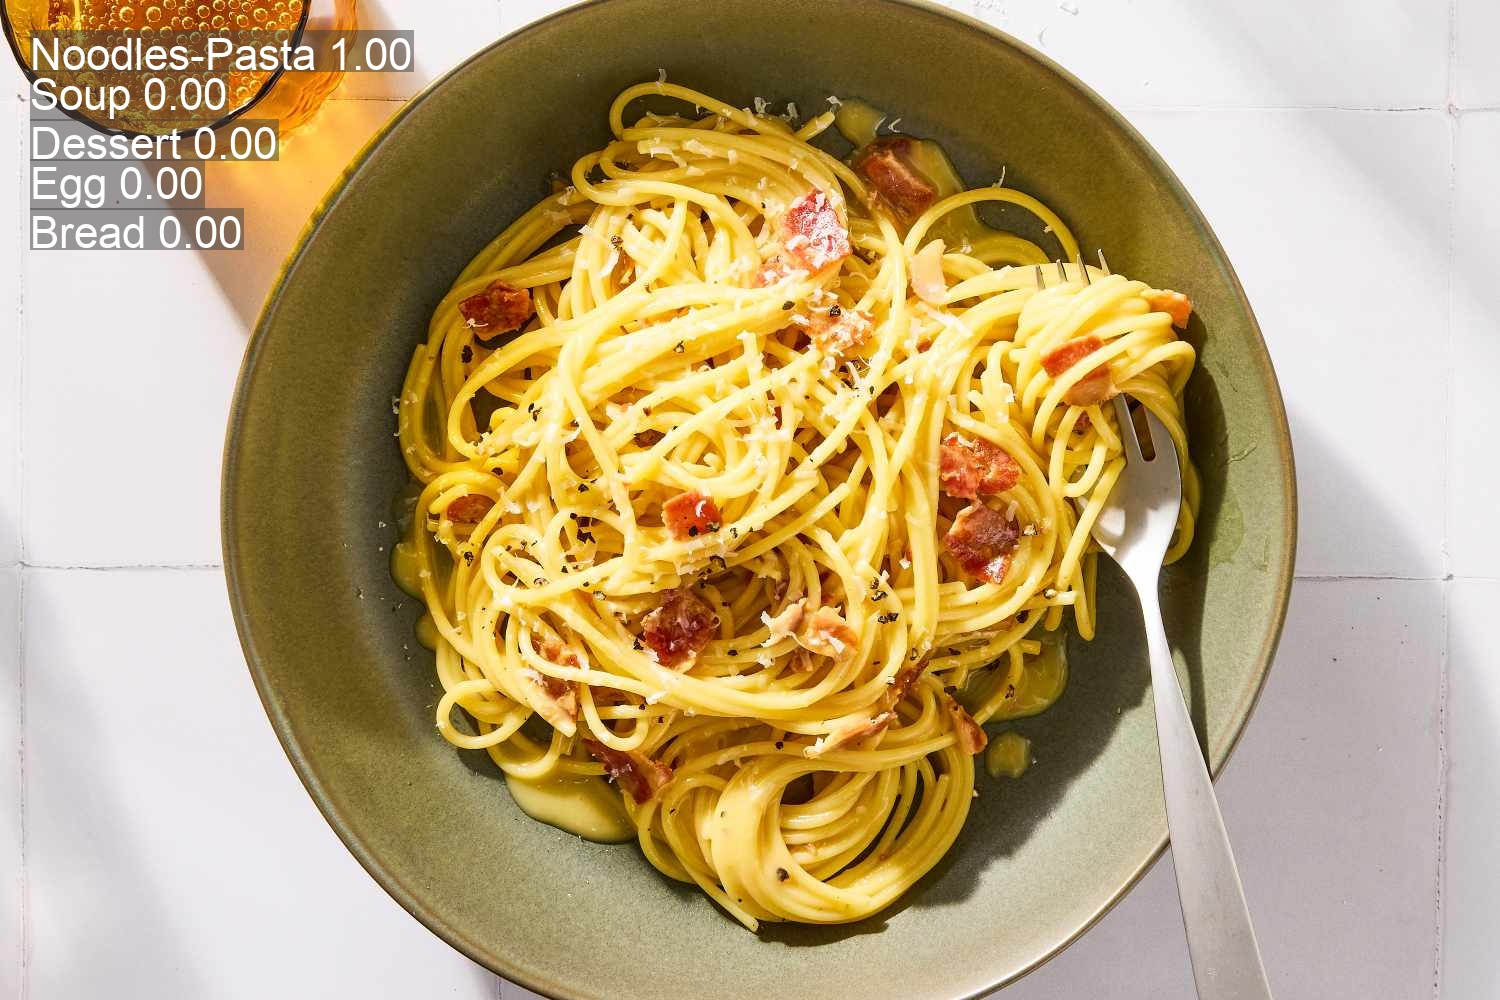

In [5]:

# --- 4) Show Top-1 and Top-5 --------------------------------------------------
import torch as th
import pandas as pd
from IPython.display import display, Image as IPyImage
import os

r = results[0]               # single image
names = model.names          # class index -> label mapping from the trained model
probs = r.probs.data if hasattr(r.probs, "data") else r.probs  # torch.Tensor

topk = min(5, probs.shape[-1])
conf, idx = th.topk(probs, k=topk)

# Convert to Python lists
idx = idx.tolist()
conf = conf.tolist()

top1_name, top1_conf = names[idx[0]], float(conf[0])
print(f"Top-1: {top1_name}  (confidence={top1_conf:.4f})")

df = pd.DataFrame({
    "rank": list(range(1, topk+1)),
    "class": [names[i] for i in idx],
    "confidence": [float(c) for c in conf]
})
display(df)

# Try to display the saved annotated image as an output
inf_dir = os.path.join(MODEL_DIR, "food11_single_inference")
# Ultralytics preserves the original filename
annot_path = os.path.join(inf_dir, os.path.basename(IMAGE_PATH))
if os.path.exists(annot_path):
    display(IPyImage(filename=annot_path))
else:
    print("(Annotated image not found; depending on version it may save to a subfolder.)")
